In [4]:
# Import necessary libraries and the encoder module
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import load_dataset
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.callbacks import CSVLogger

In [5]:
# Import from encoder.py
from encoder import tokenize_and_pad, EncoderCategoryTransformer

In [6]:
# Load GoEmotions dataset
emotion_data = load_dataset("go_emotions", "simplified")
emotion_data = emotion_data.filter(lambda x: len(x["labels"]) == 1)

all_emotions = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire",
                "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy",
                "love", "nervousness", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]

num_label = len(all_emotions)

In [7]:
# Transform labels
def one_hot_encode(labels, num_classes):
    mlb = MultiLabelBinarizer()
    mlb.fit([list(range(num_classes))])
    return mlb.transform(labels)

In [8]:
# Tokenizer for GoEmotions dataset
num_words = 10000
max_length = 120
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(emotion_data["train"]["text"])

In [9]:
# Data preparation for Transformer model
X_train_transformer = tokenize_and_pad(emotion_data["train"]["text"], tokenizer, max_length)
X_test_transformer = tokenize_and_pad(emotion_data["test"]["text"], tokenizer, max_length)
Y_train_transformer = one_hot_encode(emotion_data["train"]["labels"], num_label)
Y_test_transformer = one_hot_encode(emotion_data["test"]["labels"], num_label)

In [10]:
# Data preparation for traditional models
vectorizer = CountVectorizer(max_features=num_words)
X_train_traditional = vectorizer.fit_transform(emotion_data["train"]["text"])
Y_train_traditional = one_hot_encode(emotion_data["train"]["labels"], num_label)
X_test_traditional = vectorizer.transform(emotion_data["test"]["text"])
Y_test_traditional = one_hot_encode(emotion_data["test"]["labels"], num_label)

In [11]:
# SVM
svm_model = LinearSVC()
svm_model.fit(X_train_traditional, np.argmax(Y_train_traditional, axis=1))
y_pred_svm = svm_model.predict(X_test_traditional)
svm_accuracy = accuracy_score(np.argmax(Y_test_traditional, axis=1), y_pred_svm)
svm_precision = precision_score(np.argmax(Y_test_traditional, axis=1), y_pred_svm, average='weighted')
svm_recall = recall_score(np.argmax(Y_test_traditional, axis=1), y_pred_svm, average='weighted')
svm_f1 = f1_score(np.argmax(Y_test_traditional, axis=1), y_pred_svm, average='weighted')

c:\Users\duynt\.conda\envs\csci373\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\duynt\.conda\envs\csci373\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [12]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_traditional, np.argmax(Y_train_traditional, axis=1))
y_pred_nb = nb_model.predict(X_test_traditional)
nb_accuracy = accuracy_score(np.argmax(Y_test_traditional, axis=1), y_pred_nb)
nb_precision = precision_score(np.argmax(Y_test_traditional, axis=1), y_pred_nb, average='weighted')
nb_recall = recall_score(np.argmax(Y_test_traditional, axis=1), y_pred_nb, average='weighted')
nb_f1 = f1_score(np.argmax(Y_test_traditional, axis=1), y_pred_nb, average='weighted')

c:\Users\duynt\.conda\envs\csci373\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
# Hyperparameters for Transformer model
num_layers = 2
d_model = 256
num_heads = 8
dff = 512
input_vocab_size = num_words + 1

# Initialize and compile Transformer model
transformer_model = EncoderCategoryTransformer(num_layers, d_model, num_heads, dff, input_vocab_size, max_length, num_label)
optimizer = tf.keras.optimizers.Adam(0.0001)
transformer_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train Transformer model
history = transformer_model.fit(
    X_train_transformer, 
    Y_train_transformer, 
    batch_size=32, 
    epochs=4, 
    validation_data=(X_test_transformer, Y_test_transformer), 
    callbacks=[CSVLogger('results/go_emotions_log_0.0001.csv')]
)

Epoch 1/4
1135/1135 [==============================] - 72s 60ms/step - loss: 2.1284 - accuracy: 0.4802 - val_loss: 1.7757 - val_accuracy: 0.5497
Epoch 2/4
1135/1135 [==============================] - 68s 60ms/step - loss: 1.6322 - accuracy: 0.5697 - val_loss: 1.6195 - val_accuracy: 0.5797
Epoch 3/4
1135/1135 [==============================] - 70s 62ms/step - loss: 1.4118 - accuracy: 0.6030 - val_loss: 1.6312 - val_accuracy: 0.5728
Epoch 4/4
1135/1135 [==============================] - 71s 63ms/step - loss: 1.2032 - accuracy: 0.6476 - val_loss: 1.6872 - val_accuracy: 0.5730


In [15]:
# Evaluate Transformer model
y_pred_transformer = np.argmax(transformer_model.predict(X_test_transformer), axis=1)
transformer_accuracy = accuracy_score(np.argmax(Y_test_transformer, axis=1), y_pred_transformer)
transformer_precision = precision_score(np.argmax(Y_test_transformer, axis=1), y_pred_transformer, average='weighted')
transformer_recall = recall_score(np.argmax(Y_test_transformer, axis=1), y_pred_transformer, average='weighted')
transformer_f1 = f1_score(np.argmax(Y_test_transformer, axis=1), y_pred_transformer, average='weighted')

# Save the results to a csv file
results = pd.DataFrame({
    'Model': ['SVM', 'Naive Bayes', 'Transformer'],
    'Accuracy': [svm_accuracy, nb_accuracy, transformer_accuracy],
    'Precision': [svm_precision, nb_precision, transformer_precision],
    'Recall': [svm_recall, nb_recall, transformer_recall],
    'F1': [svm_f1, nb_f1, transformer_f1]
})

results.to_csv('results/go_emotions_results_0.0001.csv', index=False)

results

144/144 [==============================] - 3s 21ms/step


c:\Users\duynt\.conda\envs\csci373\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Accuracy,Precision,Recall,F1
0,SVM,0.517429,0.490948,0.517429,0.499132
1,Naive Bayes,0.430283,0.475189,0.430283,0.320341
2,Transformer,0.572985,0.552492,0.572985,0.548853


c:\Users\duynt\.conda\envs\csci373\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\duynt\.conda\envs\csci373\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: results/go_emotions_results_0.0001.png


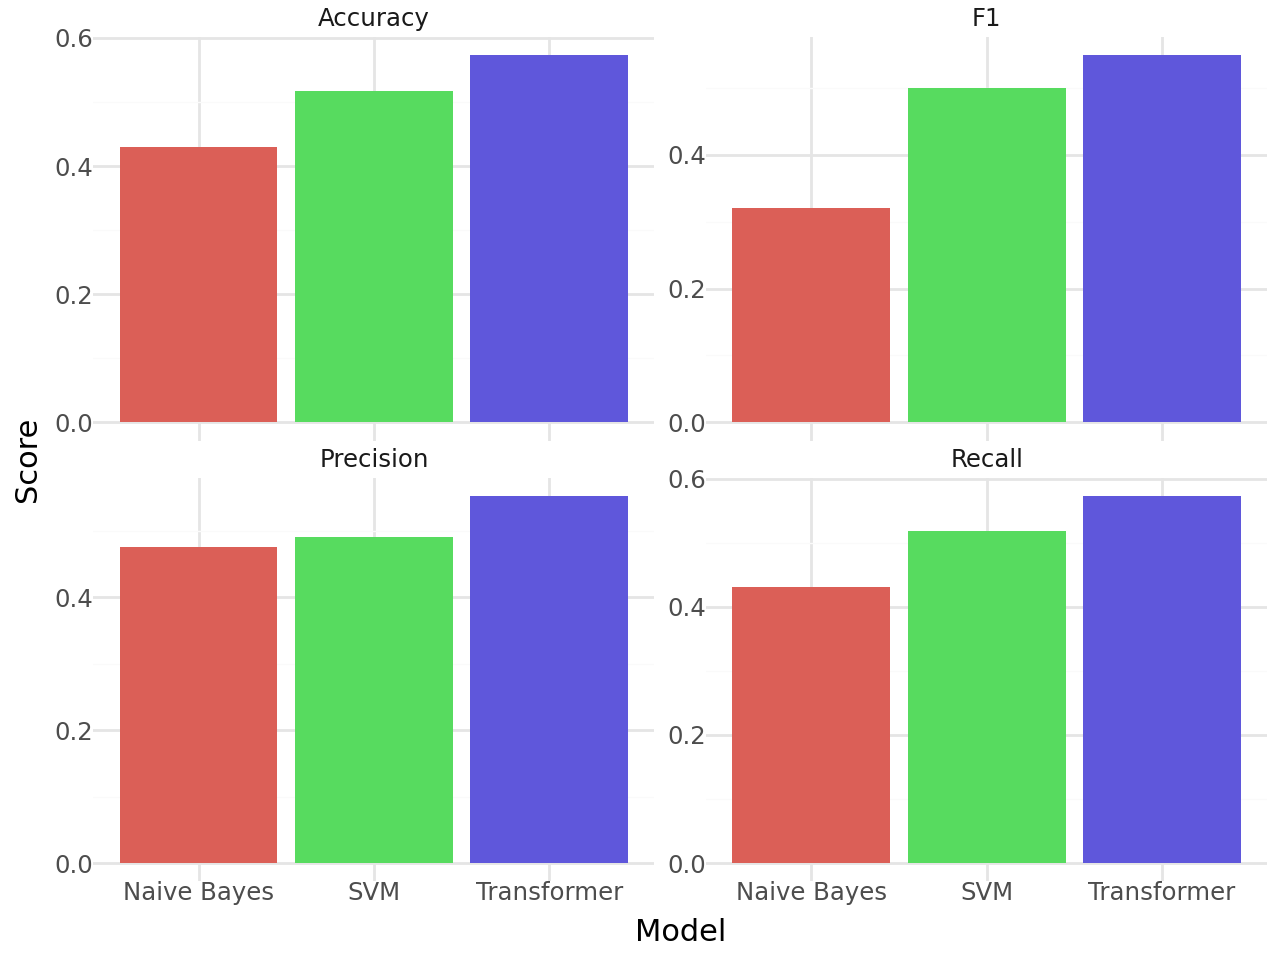

In [16]:
# Output the results with plotnine
from plotnine import *

results_long = results.melt(id_vars='Model', var_name='Metric', value_name='Score')

p = (
    ggplot(results_long, aes(x='Model', y='Score', fill='Model')) +
    geom_bar(stat='identity', position='dodge') +
    facet_wrap('~Metric', scales='free_y') +
    theme_minimal() +
    theme(legend_position='none')
)

p.save('results/go_emotions_results_0.0001.png', width=10, height=5, dpi=300)

p

c:\Users\duynt\.conda\envs\csci373\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\duynt\.conda\envs\csci373\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: results/go_emotions_history_0.0001.png


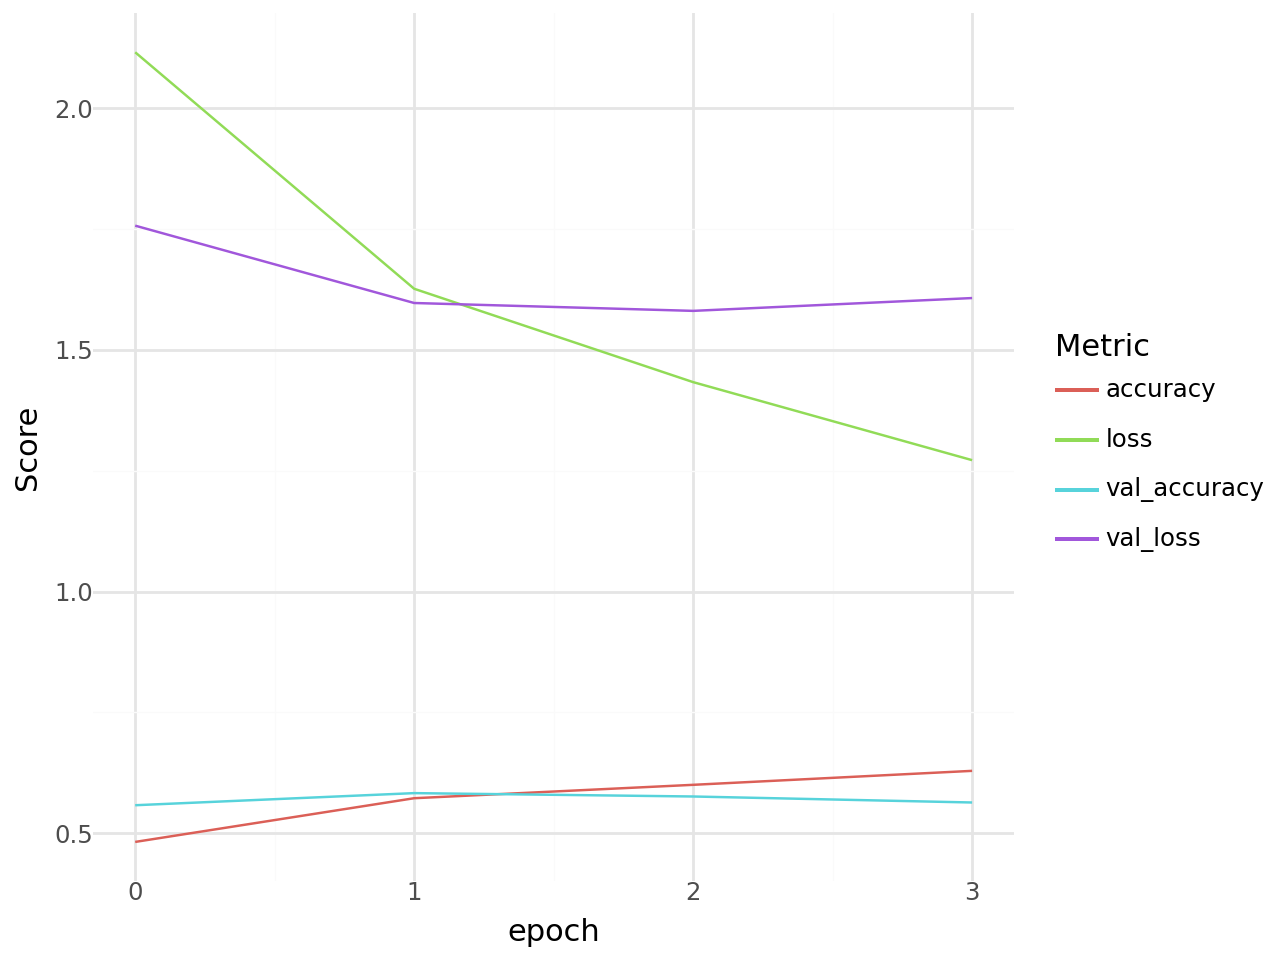

In [ ]:
# Plot the training history of the Transformer model
history_df = pd.read_csv('results/go_emotions_log_0.0001.csv')

history_df_long = history_df.melt(id_vars='epoch', var_name='Metric', value_name='Score')

p2 = (
    ggplot(history_df_long, aes(x='epoch', y='Score', color='Metric')) +
    geom_line() +
    theme_minimal()
)

p2.save('results/go_emotions_history_0.0001.png', width=10, height=5, dpi=300)

p2